# Sequence Processing with Recurrent Neural Networks

So far, we have seen how word vectors can be constructed from corpus statistics, and how they can be utilized to infer latent semantic content either in isolation (e.g. genders from names) or in relation to one another (e.g. similarities and analogies). 

For tasks involving larger linguistic units such as phrases, sentences and dialogues, we need machinery capable of processing _sequences_ or _structures_ of words.

Recurrent Neural Networks are an example of such machinery; for this assignment, you will construct a recurrent neural network that annotates each word of a sentence with a linguistically informative marker. In the simple case (and in this assignment), these markers will be POS tags. However, they can also be other kinds of tags, e.g. more fine-grained morphosyntactic [categories](https://en.wikipedia.org/wiki/Combinatory_categorial_grammar) (supertags).

This task is a case of sequence labeling.  A good reference point is Jurafsky and Martin [Chapter 9](https://web.stanford.edu/~jurafsky/slp3/9.pdf). For a fuller view of the picture, a good reference point is Alex Graves' [dissertation](https://www.cs.toronto.edu/~graves/preprint.pdf).

We will take a gradual approach, first inspecting recurrent neural networks, then moving on to data processing using high-grade word vectors before finally moving to the problem at hand. 

_(Points break up: Total points 10;  1 point each (for 2.0-2.5); 4 points(for 2.6))_

---

## Recurrent Neural Networks
Recurrent Neural Networks are a particularly interesting class of neural networks. Unlike standard fully-connected networks, which accept a fixed-size input and produce a fixed-size output over a predefined number of computational steps (i.e. network layers), RNNs instead operate on sequences of vectors. 

Computationally, feedforward networks may be seen as a trainable (but parametrically fixed) function, whereas RNNs act as continuous, stateful programs operating on sequences of inputs. 
Cognitively, this may be viewed as enhancing our system's perceptive and computational abilities with a notion of memory.
In the general case, this statefulness is captured by an intermediate hidden vector which is adjusted throughout the computation, affected by both the immediately previous version of itself __and__ the current input.

RNNs are nowadays established as the core machinery of neural sequence processing. 

A simple recurrent network (SRN or Elman network) is described by the equations:
* $h_t = \theta_h (W_h x_t + U_h h_{t-1} + b_h ) $
* $y_t = \theta_y (W_y h_t + b_y) $

where (at timestep $t$) $x_t$, $h_t$, $y_t$ are the network's input, hidden and output representations respectively, $\theta_h$, $\theta_y$ its hidden and output activation functions, and $W_h$, $U_h$, $b_h$, $W_y$, $b_y$ parametric tensors to be learned.

In [1]:
import torch
from torch import FloatTensor, LongTensor
from typing import Tuple, List, Callable, Optional

### Assignment 2.0: Our own SRN
Let's make our own simple recurrent network from scratch, to get an idea of its inner workings. To make our life just a bit simpler, we will use `torch.nn.Linear` to model the internal transformations.

Complete the `mySRN` class, which is initialized with the input $d_i$, hidden $d_h$ and output $d_o$ dimensionalities, as well as two non-linear functions $\theta_h$ and $\theta_y$, and constructs a SRN implementing three `torch.nn.Linear` layers:
1. `x_to_h`: a layer that takes $x_t$ and produces $W_h x_t$
2. `h_to_h`: a layer that takes $h_{t-1}$ and produces $U_h h_{t-1} + b_h$
3. `h_to_y`: a layer that takes $h_t$ and produces $W_y h_t + b_y$

Implement the function `step` that performs a computational step, accepting $x_t$ and $h_{t-1}$ and producing $h_t$ and $y_t$.

Implement the function `forward` that accepts a List of inputs $X$, an initial hidden vector $h_{-1}$ and iteratively applies `step` until the input sequence is exhausted, returning a List of outputs $Y$ (of the same length as $X$).

_Hint_: Note that `x_to_h` does not have a bias term $b$, since we will incorporate it into `h_to_h`

In [2]:
class mySRN(torch.nn.Module):
    def __init__(self, input_dim: int, hidden_dim: int, output_dim: int, 
                 hidden_activation: Callable[[FloatTensor], FloatTensor],
                 output_activation: Callable[[FloatTensor], FloatTensor],
                 device: str):
        super(mySRN, self).__init__()
        self.hidden_activation = hidden_activation
        self.output_activation = output_activation
        self.device = device

        # initialize layers
        self.x_to_h = torch.nn.Linear(input_dim, hidden_dim, bias=False)
        self.h_to_h = torch.nn.Linear(hidden_dim, hidden_dim, bias=True)
        self.h_to_y = torch.nn.Linear(hidden_dim, output_dim, bias=True)

        self.h = torch.rand(hidden_dim)  # initialize uniform distribution on the interval [0, 1)
        
    def step(self, x: FloatTensor, h_1: FloatTensor) -> Tuple[FloatTensor, FloatTensor]:
        Wx = self.x_to_h(x)  # activate x without bias
        Uh_1b = self.h_to_h(h_1)  # activate hidden with bias
        self.h = self.hidden_activation(Wx + Uh_1b)  # apply activation after addition of both activations
        Whb = self.h_to_y(self.h)  # activate hidden with bias
        y = self.output_activation(Whb)  # final activation from hidden activation
        return self.h, y
        
    def forward(self, X: List[FloatTensor], h_init: FloatTensor) -> List[FloatTensor]:
        init_step = self.step(X[0], h_init)
        return [init_step] + [self.step(x, self.h)[1] for x in X[1:]]
    

In practice, we do not need to write our own functions for common RNN architectures. 
Torch already provides the [necessary abstractions](https://pytorch.org/docs/stable/nn.html#recurrent-layers).

The [RNN](https://pytorch.org/docs/stable/nn.html#rnn) wrapper implements highly optimized forward routines to compute the hidden representations of a full input sequence.

Some pointers:
* Unlike our naive implementation, RNN accepts a 3-dimensional tensor of shape (seq_len, batch_shape, input_dim) rather than a list of 2-dimensional tensors
* If no initial hidden state is provided, it defaults to a zero tensor
* The class produces just the RNN hidden states; it is up to us to define the `h_to_y` transformation on top of them
* The non-linearity argument is a string; our only two choices are either `'tanh'` or `'relu'` (shorthands for `torch.nn.Tanh` and `torch.nn.ReLU` respectively)

Read the documentation (!) for further details.

A brief example is given below.

In [3]:
rnn = torch.nn.RNN(input_size=16, hidden_size=48, nonlinearity='tanh')
X = torch.rand(10, 32, 16)
h, _ = rnn(X)
print(h.shape)

torch.Size([10, 32, 48])


So, for a random input tensor of shape (seq_len, batch_size, input_dim), we get back an output tensor of shape (seq_len, batch_size, hidden_dim)

In [4]:
del mySRN, rnn, X, h

### Assignment 2.1: A faster version of the SRN
Now let's wrap an `RNN` into a custom module `myFastSRN` that implements it aside the `h_to_y` transformation.

In [5]:
class fastSRN(torch.nn.Module):
    def __init__(self, input_dim: int, hidden_dim: int, output_dim: int, 
                 hidden_activation: str,
                 output_activation: Callable[[FloatTensor], FloatTensor],
                 device: str):
        super(fastSRN, self).__init__()
        self.output_activation = output_activation
        self.device = device

        self.xh_to_h = torch.nn.RNN(input_size=input_dim, hidden_size=hidden_dim, nonlinearity=hidden_activation)
        self.h_to_y = torch.nn.Linear(hidden_dim, output_dim, bias=True)
        
    def forward(self, X:FloatTensor, h_init: Optional[FloatTensor]=None) -> FloatTensor:
        h, h_n = self.xh_to_h(X, h_init)
        output = self.h_to_y(h)
        return self.output_activation(output)

Let's see our new implementation in action. 

Initialize a random input tensor $X$ that would correspond to 32 sequences,  each of length 10, with each item having 16 features, and a `fastSRN` fit to process it, producing 42-dimensional hidden states and 2-dimension output vectors for each sequence item.

Run the SRN on the tensor and make sure the output shape is as expected.

In [6]:
X = torch.rand((32, 10, 16))
srn = fastSRN(16, 42, 2, 'relu', torch.nn.functional.tanh, 'cuda')
Y = srn(X)
print(Y.shape)

torch.Size([32, 10, 2])


/home/mik/anaconda/envs/nl.uu.mlhvl20.17.ConvMNISTClassifier/lib/python3.8/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Hopefully everything should be in order.

You may have noticed a minor complication: in order to utilize batching, we need our input sequences to be of the same length.

This however is very rarely the case in practice. A common trick against this problem is _padding_; that is, appending zero tensors to all input sequences shorter than the maximum in-batch length to make them all equally long.

As usual, torch already does the hard work for us via [pad_sequence](https://pytorch.org/docs/stable/nn.html?highlight=pad%20_sequence#torch.nn.utils.rnn.pad_sequence). Given a list of $N$ 2-dimensional tensors, each of shape (seq_len$_n$, input_dim), it will construct a 3-d tensor of shape ($max_{n \in N}${seq_len$_n$}, N, input_dim).

An example:

In [7]:
x_1 = torch.rand(1, 16)  # a sequence of 1, 16-dimensional item
x_2 = torch.rand(7, 16)  # a sequence of 7, 16-dimensional items
x_3 = torch.rand(5, 16)  # a sequence of 5, 16-dimensional items

X = torch.nn.utils.rnn.pad_sequence([x_1, x_2, x_3])  

# Can you guess what the shape of X is?
print(X.shape)

torch.Size([7, 3, 16])


In [8]:
del x_1, x_2, x_3, X

## Pretrained Word Embeddings
Moving on-- last assignment, we saw how to train our own word embeddings using a miniature toy corpus. Now, we will see how to easily employ high-quality pretrained word vectors and, later on, how to utilize them for further downstream tasks.

We are going to use [spaCy](https://spacy.io/). SpaCy is a high-level NLP library that provides a ton of useful functionalities, but we will only focus on its pretrained embeddings for this assignment.

Before proceeding, [install spacy](https://spacy.io/usage) using your python package manager (e.g. `pip install spacy`).

In [9]:
import spacy

SpaCy comes with a lot of different-size models for different languages. 

We will need to download the small english model for the exercises to follow. You can either do it on a new terminal window (optimal, if you are running this assignment through a virtual environment) or by simply running the magic command below. 

In [10]:
!python3 -m spacy download en_core_web_lg

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_lg')


After having downloaded the model, we can load it as follows (you may need to restart your notebook after the download is complete):

In [11]:
nlp = spacy.load('en_core_web_lg')

We can then use the loaded model to process a sentence and obtain its word vectors, a List of 300-dimensional numpy arrays.

In [12]:
doc = nlp('this is a sentence of 7 words')  # the processed sentence
vectors = list(map(lambda x: x.vector, doc))  # its vectors
print('We have {} vectors..'.format(len(vectors)))
print('..each of shape {}'.format(vectors[0].shape))

We have 7 vectors..
..each of shape (300,)


And then finally convert them into torch tensors.

In [13]:
torch_vectors = torch.tensor(vectors)
print(torch_vectors.shape)

torch.Size([7, 300])


Or, in the case of multiple sentences:

In [14]:
# Example sentences
sentences = ['This is a sentence', 'This is another sentence.']

# Parallel processing with spacy
docs = list(map(nlp, sentences))

# Convert each processed sentence into a list of vectors
vectors = map(lambda doc: [word.vector for word in doc], docs)

# Convert each list of vectors into a 2-d torch tensor
tensors = list(map(lambda sentence_vectors: torch.tensor(sentence_vectors), vectors))

## POS Tagging
Given our pretrained embeddings, we may represent sentences as _sequences of vectors_, which is exactly the format expected by an RNN.
We will now try to train an SRN to iterate over a sentence and assign part of speech tags to each of its words.

### Assignment 2.2: Examining the data


First, let's load and inspect our datafiles.

The pickle file contains three items:
1. `sentences`: a List of strings (-sentences)
1. `postags`: a List of Lists of strings (-POS tags)
2. `pos_to_int`: a Dictionary from strings to ints (mapping each POS tag to a unique identifier)
 

In [29]:
import pickle
with open('../data/TRAIN.p', 'rb') as f:
    sentences, postags, pos_to_int = pickle.load(f)

In [30]:
assert all(list(map(lambda s, p: len(s.split()) == len(p), sentences, postags)))

Now, let us take a moment to understand the data a bit more. 
The POS tags in this dataset are in the style of the Penn Treebank. Find the top 20 most common tags and plot a histogram of their frequencies. If you are curious, also find out what these tags mean linguisically! https://www.ling.upenn.edu/courses/Fall_2003/ling001/penn_treebank_pos.html

Text(0.5, 0, 'Amount')

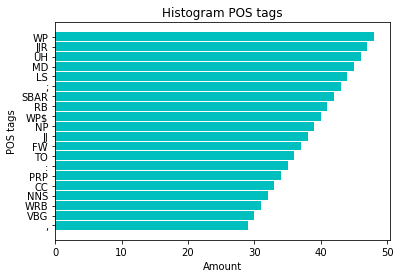

In [31]:
import numpy as np
from matplotlib import pyplot as plt
import collections

count_dict = collections.Counter(pos_to_int)
count_dict = dict(reversed(count_dict.most_common(20)))

y_pos = np.arange(len(count_dict.keys()))

X = list(count_dict.values())

plt.barh(y_pos, X, 0.9, color='c')

plt.yticks(y_pos, count_dict.keys())

plt.title('Histogram POS tags')
plt.ylabel('POS tags')
plt.xlabel('Amount')

Next, we need to convert our data to numeric form.

### Assignment 2.3: Tensorizing sentences
Convert sentences to their tensor format, as done earlier (this may take a while). 

<div class="alert alert-block alert-warning">
<b>Important!</b>
Since the sentences are pre-tokenized (i.e. they are provided as sequences of words rather than strings), we need to change the processing call to ensure the output vectors are aligned with our tokenization.
</div>

In [35]:
docs = list(map(lambda sentence: spacy.tokens.doc.Doc(nlp.vocab, words=sentence.split()), sentences))

doc_vectors = map(lambda doc: [word.vector for word in doc], docs)
doc_tensors = list(map(lambda sentence_vectors: torch.tensor(sentence_vectors), doc_vectors))

# We no longer need the docs and numpy arrays
del doc_vectors, docs

Similarly, we will use `pos_to_int` to convert the POS sequences into tensors.

In [36]:
pos_numeric = list(map(lambda pos_sequence: [pos_to_int[pos] for pos in pos_sequence], postags))
pos_tensors =  list(map(lambda pos_num_sequence: torch.tensor(pos_num_sequence), pos_numeric))

In the first assignment, we saw how to split our dataset into a training and a validation set. 

Do the same here, splitting the sentences, postags and their corresponding tensors into a training and a validation set.

In [37]:
from sklearn.model_selection import train_test_split

sentences_train, sentences_val, postags_train, postags_val, X_train, X_val, Y_train, Y_val \
    = train_test_split(sentences, postags, doc_tensors, pos_tensors)

assert len(X_train) == len(Y_train) == len(sentences_train)
assert len(X_val) == len(Y_val) == len(sentences_val)

Again, following along the first assignment, we will wrap our tensors into a `Dataset` and a `DataLoader`.

Since our data are not Tensors but rather Lists of Tensors of uneven lengths, we need to write our own Dataset wrapper.
The wrapper only needs to implement two functions; `__len__`, which expects no arguments and returns the number of samples in the dataset, and `__getitem__`, which accepts an index `idx` and returns the input-output pair `X[idx]`, `Y[idx]`.

Similarly, the Dataloader needs to process the list of input-output pairs produced by the Dataset using `pad_sequence`, as seen earlier.

### Assignment 2.4: Padding
#### a) What is the advantage to applying padding on the batch rather than the entire dataset?

_your answer here_

#### b) Fill in the code for `UnevenLengthDataset` class, implementing its two core functions.

Then, complete the function `pad_batch` which takes a list of 
(x$_i$, y$_i$) pairs and produces the pair of their paddings: (X, Y).

Given the two, the `DataLoader` object defined can iterate over the Dataset yielding uniform batches ready to be consumed by an RNN.

In [ ]:
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset, DataLoader


class UnevenLengthDataset(Dataset):
    def __init__(self, X: List[FloatTensor], Y: List[LongTensor]) -> None:
        NotImplemented
        
    def __len__(self) -> int:
        NotImplemented
        
    def __getitem__(self, idx: int) -> Tuple[FloatTensor, LongTensor]:
        NotImplemented
    
    
def pad_batch(batch: List[Tuple[FloatTensor, LongTensor]]) -> Tuple[FloatTensor, LongTensor]:
    # .. 
    NotImplemented
        
train_dataset = UnevenLengthDataset(X_train, Y_train)
train_dataloader = DataLoader(train_dataset, 
                              collate_fn=pad_batch,
                              shuffle=True,
                              batch_size=32)

val_dataset = UnevenLengthDataset(X_val, Y_val)
val_dataloader = DataLoader(val_dataset,
                            collate_fn=pad_batch,
                            shuffle=False,
                            batch_size=32)

What does a batch look like, shape-wise?

In [ ]:
#Your code here

So far so good. On to the network.

### Assignment 2.5: Utility Functions
Remember how we defined our training and validation functions for the first assignment?

You will need to do the same here.
Note that while you can use the given code as a guideline, just copying it won't do the trick; unlike a feedforward net, a recurrent network produces a 3rd order output tensor, of shape (max_seq_len, batch_size, num_output_classes).

Similarly, our target Y is a 2nd order tensor of shape (max_seq_len, batch_size).

You will need to properly treat the extra dimensional of both the output and the target, since loss functions expect an order 2 output tensor and an order 1 target tensor. 

Complete the functions `train_batch`, `train_epoch`, `eval_batch` and `eval_epoch`.

In [ ]:
def accuracy(predictions: LongTensor, truth: LongTensor, ignore_idx: int) -> Tuple[int, int]:
    """
        Given a tensor containing the network's predictions and a tensor containing the true values, as well
        as an output value to ignore (e.g. the padding value), computes and returns the total count of non-
        ignored values as well the total count of correctly predicted values.
        
        predictions: The network's predictions.
        truth: The true output labels.
        ignore_idx: The output padding value, to be ignored in accuracy calculation.
    """
    
    correct_words = torch.ones(predictions.size())
    correct_words[predictions != truth] = 0
    correct_words[truth == ignore_idx] = 1

    num_correct_words = correct_words.sum().item()
    num_masked_words = len(truth[truth == ignore_idx])

    return predictions.shape[0] * predictions.shape[1] - num_masked_words, num_correct_words - num_masked_words


def measure_accuracy(network: torch.nn.Module,
                    dataloader: DataLoader,
                    device: str) -> float:
    """
        Given a network, a dataloader and a device, iterates over the dataset and returns the network's accuracy.
    """
    correct = 0
    total = 0
    for x_batch, y_batch in dataloader:
        pred = network(x_batch.to(device))
        local_total, local_correct = accuracy(pred.argmax(dim=-1), y_batch.to(device), ignore_idx=0)
        correct+= local_correct
        total+= local_total
    return correct/total
    

def train_batch(network: torch.nn.Module,
                X_batch: FloatTensor,
                Y_batch: LongTensor,
                loss_fn: Callable[[FloatTensor, FloatTensor], FloatTensor],  
                optimizer: torch.optim.Optimizer) -> float:
    
    NotImplemented

def train_epoch(network: torch.nn.Module, 
                dataloader: DataLoader,
                loss_fn: Callable[[FloatTensor, FloatTensor], FloatTensor],
                optimizer: torch.optim.Optimizer, 
                device: str) -> float:
    
    NotImplemented

def eval_batch(network: torch.nn.Module,
                X_batch: FloatTensor,
                Y_batch: LongTensor,
                loss_fn: Callable[[FloatTensor, LongTensor], FloatTensor]) -> float:
    
    NotImplemented

def eval_epoch(network: torch.nn.Module, 
                # a list of data points x
                dataloader: DataLoader,
                loss_fn: Callable[[FloatTensor, LongTensor], FloatTensor],
                device: str) -> float:
    
    NotImplemented

### Assignment 2.6: SRN POS tagging
Define a simple recurrent network, with input size compatible with the vector dimensionality, output size compatible with the number of output classes (the number of different POS tags + 1) and a hidden size of your own choice. What is a reasonale choice?

#### a) Why do we need to add 1 to the number of output classes?

_your answer here_

#### b) Implementation

Use `"tanh"` as your hidden layer activation, and choose **an appropriate combination of output activation and loss function** (consider the task at hand, and refer to the documentation if in doubt- refer to tutorial as well!).

Then instantiate an optimizer over your network, and train it for a number of epochs, measuring and printing all metrics in the process (train and validation loss and accuracy).

_Hint_: Use `measure_accuracy` (defined earlier) to obtain accuracy.

Plot the loss curves over the training process.

In [ ]:
srn = NotImplemented
opt = NotImplemented
loss_fn = NotImplemented

In [ ]:
# Your training script here

NotImplemented

In [ ]:
# Your plotting here

NotImplemented

The test accuracy on this task should be well over 90%. If you are getting an accuracy much below this, check your code, play with your hyperparameters and try to improve. 

#### c) What is your final accuracy?

your answer here

#### d) A little error analysis
Find 2-4 sentences with wrong tags. Can you say why these mistakes are made?
Optionally, feel free is do a full error analysis. What are the most commonly confused tags for an English POS tagger?

your answer here

**Congratulations!** 🎉 You are done with the required part! 

### Optional

RNNs have limited expressive capacity that can be surpassed by more complicated variants such as [Gated Recurrent Units](https://en.wikipedia.org/wiki/Gated_recurrent_unit) and [Long Short-Term Memory Units](https://en.wikipedia.org/wiki/Long_short-term_memory); replacing your RNN with those could easily improve its performance.

If you found the previous part easy and are already done, you can use other neural architectures to do the same task on the same dataset, and compare their performance.  (There will not be support provided for this, or points, but you are welcome to explore this for your own understanding :))

Whatever your design choices are, keep the torch documentation close at all times! Do not reinvent the wheel, use existing abstractions whenever possible (but make sure you use them the right way!). Take measures against overfitting: regularize with dropout and/or weight decay and keep track of the validation set performance to stop training early if needed.